# OCR and Logistic Regression
In this handin you will build classifiers for optical character
recognition (OCR). You should use Python 3 (preferably 3.5) and NumPy for the
programming parts. The models can be implemented with relatively few
lines of actual code if expressed using matrices and vectors. Python
and NumPy are **much much** faster when you express 
computation using vectorized code and matrix products instead of for-loops,
so the key is in understanding matrix products. 

In this document we go through the models in quite a lot of detail to
ease the understanding. We use matrix and vector notation throughout
since it simplifies the exposition, so you might as well get used to it.
In mathematical formulas we shall think of all our vectors being column vectors.

The exact deliverables are stated after the exercise descriptions.

### Formalities

You can write your final report in Danish if you prefer.  The maximal
report length is 5 pages. You are allowed to be up to 3 members in a
group.  You are encouraged to discuss the exercise between groups and
help each other as much as possible <b>without of course copying each
other's work</b>. Particularly, discussing the quality of your classifiers
is probably a good idea to get an indication of whether you are doing it
correctly. For these discussions and additional questions use the
discussion forum on the Blackboard course site.
Bonus questions may be skipped, but you are encouraged to try and at least think
about answering them.


### Important remarks
* You may run into numerical issues. Deal with them...

* Note that running the experiments may be rather slow if you have not been able to optimize your code properly, so start running experiments early -- don't wait until the day before the deadline!

# The data
First, let's see how we load the data and visualize it.
There are two data sets. The famous MNIST-Digits data set is a classic machine learning data set, and the AU-Digits data set generated by you and your predecessor Machine Learning students. Each data set is split in two: the training and the test set.

We will release the AU-Digits data set as soon as we have processed the digits you have drawn this year, so for now we focus on the MNIST data set.

In [61]:
%matplotlib inline
import numpy as np

# Change this to the AU digits data set when it has been released!
train_file = np.load('Data/auTrain.npz')
print(train_file.keys())  # ['labels', 'images']
images = train_file['digits']
labels = train_file['labels']
print('Shape of input data: %s' % (images.shape,))
print('Shape of input labels: %s' % (labels.shape,))

# Change this to the AU digits data set when it has been released!
test_file = np.load('Data/auTest.npz')
print(test_file.keys())
images_test = test_file['digits']
print('Shape of test input data: %s' % (images_test.shape,))
labels_test = test_file['labels']
print('Shape of test labels data: %s' % (labels_test.shape,))

['digits', 'labels']
Shape of input data: (10380, 784)
Shape of input labels: (10380,)
['digits', 'labels']
Shape of test input data: (2580, 784)
Shape of test labels data: (2580,)


With some of the data loaded, let's visualize some of the input images.
The same code can be useful later for visualizing the weight vector.

tr2_size:  (784, 1)
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.

([], <a list of 0 Text xticklabel objects>)

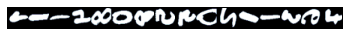

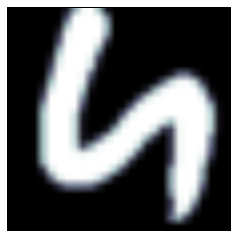

In [198]:
# show the first 16 digits from training set
import matplotlib.pyplot as plt

tr = images[0:16,:].T
plt.imshow(tr.reshape(28, -1, order='F'), cmap='bone')
plt.yticks([])
plt.xticks([])
plt.figure()
# show the first 16 twos from training set
idx1 = (labels == 2)
img27 = images[idx1, :]
tr2 = img27[0:1, :].T
print('tr2_size: ', tr2.shape)
print(tr2)
plt.imshow(tr2.reshape(28, -1, order='F'), cmap='bone')
plt.yticks([])
plt.xticks([])

# Background on Logistic Regression

In logistic regression we model the target function as a probability distribution
$p(y\mid x)$.
This probability distribution is defined by the logistic function
$\sigma(z) = 1/(1+e^{-z})$
over a linear function of the input data,
$z = \sum_{i=0}^d \theta_i x_i = \theta^\intercal x$,
that is parameterized by the vector $\theta$.
As in the lectures and the first coding exercise,
we encode the bias variable into the input vectors as $x_0$ and force
$x_0 = 1$ on all data points (Note that you have amend the input data with the all ones column).

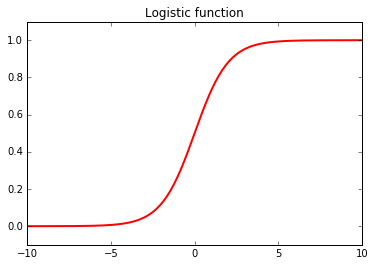

In [54]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1 + np.exp(-x))

x = np.linspace(-10, 10, 200)
plt.plot(x, sigmoid(x), 'r', linewidth=2)
plt.axis([-10, 10, -0.1, 1.1])

plt.title('Logistic function')

The logistic function is a nice smooth function with simple
derivaties,
$\frac{\partial \sigma }{\partial z} = (1-\sigma(z))\sigma(z)$,
which makes it pleasing to work with.

The model becomes,

$$
p(y \mid x, \theta) = \left \{
\begin{array}{l l}
  \sigma(\theta^\intercal x)
  & \text{ if } y=1  \\
  1 - \sigma(\theta^\intercal x)
  & \text { if } y=0,
\end{array}
\right.
$$

that is, the probability that $y = 1$ given $x$ and $\theta$
is the probability of getting heads with
a biased coin, where the bias is $\sigma(\theta^\intercal x)$.
Given a fixed $\theta$ we can use the function $p$ to make classification by
returning the most likely class.

The input is a labeled dataset $D = (X, Y) = \{(x_i, y_i) \mid i = 1, \dots, n \}$, where $x_i \in \{1\} \times \mathbb{R}^d$ is the (d+1)-dimensional data point (with the first dimension used for the bias 1)
and $y_i \in \{0,1\}$ is its label.

Let us think of $X$ as an $n \times (d+1)$ matrix, such that the data points are given as its rows.
Let us also arrange the labels as a $n$-dimensional vector $y$.

Let us stress now that the entries of $y_i$'s are not probabilities, but instead actual realisation of events.

We assume (as always) that the points in $D$ are independently sampled from the unknown distribution.
This means that under our model, for a fixed parameter vector $\theta$, the likelihood of the data is precisely

$$
p(D \mid \theta)
= \prod_{(x,y)\in D}
  p(y \mid x,\theta)
= \prod_{(x,y)\in D}
  \sigma(\theta^\intercal x )^{y}
  (1-\sigma(\theta^\intercal x))^{1-y}
$$

Notice the last equality, which gives a convenient way of expressing
the probability $p(y \mid x,\theta)$ as a product.
You should convince yourself that it is true; recall that $y$ is either 0 or 1.

As derived in class the negative log likelihood (cross entropy) is:
$$
\mathrm{NLL}(D\mid \theta)
= - \sum_{i=1}^n
y_i \ln(\sigma(\theta^\intercal x_i)) +
(1-y_i) \ln(1-\sigma(\theta^\intercal x_i))
$$
and the gradient (vector) is
$$
\nabla \mathrm{NLL}(D \mid \theta)
= \frac{\partial \mathrm{NLL}}{\partial \theta}
= -X^\intercal(Y-\sigma(X\theta))
$$
and we defined the cost function to be $E_\textrm{in} = \frac{1}{n} \mathrm{NLL}$, which of course means $\nabla E_\textrm{in} = \frac{1}{n} \nabla \mathrm{NLL}$.

Your job is to implement a gradient descent algorithm that finds a good $\theta$
by minimizing the in-sample error (or negative log likelihood).
We have provided a simple code structure for you to follow below.
**You should make a small test set to work on initially to reduce test time during development.**

# Background on gradient descent

The basic gradient search (batch gradient descent) algorithm for minimizing a (convex) function $F(\theta)$ is an iterative procedure that in each step updates the current solution by the equation
$$
\theta = \theta - \eta \nabla F(\theta)
$$
where $\eta$ is the *learning rate*, that is, the size of each step taken in gradient descent.

With a sufficiently small learning rate $\eta$ in each step (it can vary between iterations), we should see decreasing values of $F(\theta)$ until we are (approximately) at the global minimum. On the other hand, with too small learning rate, the convergence might be too slow.

### Stochastic gradient descent

Since each step in basic gradient descent needs to consider the entire data set to compute the gradient, each step can be very slow. **Stochastic gradient descent** (SGD) is a much faster method that uses randomization to avoid looking at all the data points in each step.

In SGD, our cost function $F$ must be an average over all the points, that is a function on the form $F(\theta) = \frac{1}{n} \sum_{i = 1}^n F_i(\theta)$. Notice that this is the case for logistic regression considered above.
When the cost function is an average, the gradient of the cost becomes simply
$\nabla F(\theta) = \frac{1}{n} \sum_{i=1}^n \nabla F_i(\theta) = E_{i}[\nabla F_i(\theta)]$.
In SGD we estimate $\nabla F(\theta)$ by picking a random data point $i$ and computing $\nabla F_i(\theta)$. This is an unbiased estimator for $\nabla F(\theta)$ which we can use instead of $\nabla F(\theta)$ at each iteration.

In practice we will never sample a random $i$ at each iteration, but instead we approximate the above method by running multiple so-called *epochs* where the data is processed in a random order.
At the beginning of each epoch, we output the current true value of $F(\theta)$, and we shuffle the data set before processing each data point as above.
There are built-in fast vectorized shuffling methods in NumPy so you don't have to write your own shuffling procedure.

### Minibatch stochastic gradient descent

In SGD described above, the estimate of $\nabla F(\theta)$ has a high variance since it only considers a single data point $i$. The idea of minibatch SGD is to more than one sample from the dataset when estimating the gradient to decrease the variance while maintaining the advantage of each iteration being fast. Namely, we pick a minibatch size $k$ (typically between 10 and 50) and sample $i_1, i_2, \dots, i_k$, and then we compute the better estimator (in terms of variance) $\frac{1}{k} \sum_{j=1}^k \nabla F_{i_j}(\theta)$ for $\nabla F(\theta)$. As for SGD, in practice we will approximate that by running epochs where the data is shuffled at the beginnning of each epoch, after which all datapoints are processed $k$ at a time in the shuffled order.

While there exist sophisticated stop criteria to decide when we have run enough epochs,
in our code below we take the simple approach of running for a fixed number of epochs.

You rang sir/miss
Shape of input data: (10380, 784) (10380,)
(10380,)
cost:  [[ 0.69281329]] 0
Shape of input data: (2580, 784) (2580,)
TESTING
[[ 0.5]]
[[ 0.42555748]]
rights:  503
wrongs:  13
errorRate:  0.025193798449612403


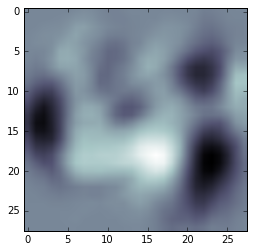

In [288]:
import numpy as np
import matplotlib.pyplot as plt

def load_data(file):
    """Loads the training data from file"""
    # Change this to the AU digits data set when it has been released!
    train_file = np.load(file)
    images = train_file['digits']
    labels = train_file['labels']  
    print('Shape of input data: %s %s' % (images.shape, labels.shape))
    return images, labels

def logistic(z):
    """ 
    Computes the logistic function to each entry in input vector z.
    Remember: logistic(-x) = 1 - logistic(x)

    Args:
        z: A vector (numpy array) 
    Returns:
        A new vector of the same length where each entry is the value of the 
        corresponding input entry after applying the logistic function to it
    """
    
    if z.any() <= 1000:
        return 1/(1 + np.exp(-z))
    else:
        return np.exp(z)/(np.exp(z)+1)

        

def log_cost(X, y, w, reg=0):
    """
    Compute the regularized cross entropy and the gradient under the logistic regression model 
    using data X,y and weight vector w

    Args:
        X: A 2D numpy array of data points stored row-wise (n x d)
        y: A 1D numpy array of target values (n x 1)
        w: A 1D numpy array of weights (d x 1)
        reg: Optional regularization parameter
    Returns:
        cost: Average Negative Log Likelihood of w
        grad: The gradient of the average Negative Log Likelihood at w
    """
    n = y.shape[0]
    res = 0
    #Calculating NLL:
    
    for i in range(0, n-1):
        sigma_w_X = logistic(np.dot(w.reshape(1,-1),X[i, :].reshape(-1,1)))
        
        if sigma_w_X < 10**-6:
            sigma_w_X = np.array([[0.00001]])
            
        
        if sigma_w_X == 1:
            sigma_w_X = np.array([[0.9999]])       
            
        if y[i] == 0:
            res+=np.log(1-sigma_w_X)
        else:
            res += np.log(sigma_w_X)
            
    nll = -res
    cost = nll/n
    grad = (np.dot(-np.transpose(X), (y.reshape(-1,1)-logistic(np.dot(X, w)))))
    return cost, grad

def batch_grad_descent(X, y, w=None, reg=0):
    """ 
    Run Batch Gradient Descent on data X,y to minimize the NLL for logistic regression on data X,y
    Args:
        X: A 2D numpy array of data points stored row-wise (n x d)
        y: A 1D numpy array of target values (n x 1)
        w: A 1D numpy array of weights (d x 1)
        reg: Optional regularization parameter
    Returns:
        Learned weight vector (d x 1)
    """
    n = 784
    reg = 0.03
    old_cost = 1000
    
    if w is None:
        w = np.zeros((X.shape[1], 1))
    
    for i in range(100):
        cost, gradient = log_cost(X, y, w)
       
        if old_cost <= cost:
            print('STOPPED at ', i, 'cost: ', cost)
            return w
         
        old_cost = cost
        if i%100 == 0:
            print('cost: ', cost ,i)
            
        w = w - reg*(1/n)*gradient
           
    return w

def mini_batch_grad_descent(X, y, w=None, reg=0, batchsize=16, epochs=10):
    """
    Run Mini-Batch Gradient Descent on data X,y to minimize the NLL for logistic regression on data X,y
    The input defines mini-batch size and the number of passess through the data set (epochs)

    Args:
        X: A 2D numpy array of data points stored row-wise (n x d)
        y: A 1D numpy array of target values (n x 1)
        w: A 1D numpy array of weights (d x 1)
        reg: Optional regularization parameter
        batchsize: Number of data points to use in each batch
        epochs: Number of times to go over all data points
    Returns:
        Learned weight vector (d x 1)
    """
    print('Please implement me and use "batchsize" data points in each gradient computation')
    if w is None:
        w = np.zeros(X.shape[1])
    n = X.shape[0]
    
    return w

def main():
    """An example main method. You should replace this with whatever you need."""
    print('You rang sir/miss')
    digits, labels = load_data('Data/auTrain.npz')
    idx1 = (labels == 2)
    idx2 = (labels == 7)
    print(idx1.shape)
    img27 = digits[idx1 | idx2,:] 
    lab27 = labels[idx1 | idx2]
    lab27[lab27==2] = 0
    lab27[lab27==7] = 1

    w = batch_grad_descent(img27, lab27)

    #print(w)
    #gpe = np.dot(lab27,img27).reshape(-1,1)
    plt.imshow(w.reshape(28, -1, order='F'), cmap='bone')
    
    #testing on auTest data
    test_digits, test_labels = load_data('Data/auTest.npz')
    test_idx1 = (test_labels == 2)
    test_idx2 = (test_labels == 7)

    test_img27 = test_digits[test_idx1 | test_idx2,:] 
    test_lab27 = test_labels[test_idx1 | test_idx2]
    test_lab27[test_lab27==2] = 0
    test_lab27[test_lab27==7] = 1
    
    
    print('TESTING')
    y = np.dot(test_img27, w)
    rights = 0
    wrongs = 0
    print(logistic(np.array([[0]])))
    print(logistic(np.array([[-0.3]])))
    
    for i in range(0,y.shape[0]):
        # here we could also check if logistic(y[i]) >= 0.5 it is the same because logistic(0)=0.5.
        if y[i] >= 0:
            y[i] = 1
        else:
            y[i] = 0
            
    test_lab27.reshape(-1,1)
    for i in range(0,y.shape[0]):
        if y[i]==test_lab27[i]:
            rights += 1
        else:
            wrongs += 1
            
    print('rights: ', rights)
    print('wrongs: ', wrongs)
    print('errorRate: ', wrongs/y.shape[0])
    
    
    
    """
    for i in range(test_img27.shape[1]):
        wdotX = np.dot(test_img27[i, :].reshape(-1,1),w.reshape(1,-1))
        
        sigma_w_X = logistic(wdotX)
        print(sigma_w_X)
        if sigma_w_X.all() > 0.5:
            y[i] = 0
            
        elif sigma_w_X.all() <= 0.5:
            y[i] = 1
    """      

if __name__ == '__main__':
    main()

# Deliverables
* Implement batch and mini-batch gradient descent for logistic regression.
* Test both gradient descent implementations on images of twos and sevens and compute the number of misclassifications. You should train on data from the training set and test on the test set.
* Implement a full OCR classifier with logistic regression using the all-vs-one technique. Here you are free to choose between full-batch and mini-batch gradient descent
* Bonus Exercise: Add regularization to the cost function and see if you can improve the performance (remember not to apply regularization to the bias parameter)
* Bonus Exercise: Test your implementation on the MNIST digits and compare the results to the AU Digits

Your code file must follow the given layout with functions log_grad, batch_grad_descent, mini_batch_gradient_descent that must implement the interface described in the functions descriptions. The remaining part you can design any way you desire.

Besides your Python file, save the best parameters you have found in a file with 
<tt>np.savez("params.npz", theta=best_theta)</tt> and hand it in. The parameters should be optimized for the auDigits data set classifying whether a digit is 2 or a 7.

Note that the file should not execute any functions when imported as a module, so you should wrap the call to your main function in <tt>if \_\_name\_\_ == "\_\_main\_\_"</tt>. For more information see the Python documentation on \_\_main\_\_.
Save the files in a zip archive and upload it to Blackboard with your report.

## Report
In your report, you should shortly explain your algorithms and the choices you have made.
You should include a plot of some of the digits that your classifier makes mistakes on -- and discuss why that may be.

To show the performance of your gradient descent implementation include a plot of the cost function as a function
of the number of steps taken. You should compare the running time and the convergence/output quality of mini-batch and full-batch gradient descent.

You should provide a figure that shows the parameter vectors for the 
case of classifying 2s versus 7s, and for the 10 all vs.~one classifiers.
Furthermore, your report should include results for the pairwise
computations (at least two vs seven) as well as the results for the full classifier on the AU data set.

If you add regularization, include the results for the regularized versions of the cost function and gradient and
compare the result with the unregularized implementation.

Furthermore you must answer the following theoretical questions
(although the bonus question is optional).


* Sanity Check:
  What happens if we randomly permute the pixels in each image (with the
  same permutation) before we train the classifier? Will we get a
  classifier that is better, worse, or the same? Give a short explanation.

* Linear Separable:
  If the data is linearly separable, what happens
  to weights when we implement logistic regression with gradient
  descent? That is, how do the weights that minimize the negative log likelihood look like?
  Assume that we have full precision (that is, ignore floating point errors).
  We can run gradient descent on the data set for as long as we want (suppose God helps you).
  Now what will happen with the weights in the limit?
  Do they converge to some fixed number (fluctuate around it) or do they
  keep increasing in magnitude (absolute value)?
  Give a short explanation for your answer.
  What happens if we add regularization?

* Bonus Question: Convexity of negative log likelihood
  Show that the negative log likelihood function for logistic regression is convex.
  Is it still convex if we add regularization?

# Multinomial/Softmax  Regression

In this exercise we generalize logistic regression to handle $K$
classes instead of 2. This is known as Multinomial or Softmax
regression and we will use the exact same approach as for logistic
regression, but it becomes a little more technical due to the extra
classes.

In Softmax regression we are classifying into $K$ classes (instead
of 2 for logistic regression).  We encode the target values, $y$, as a vector of
length $K$ with all zeros except one which corresponds to the class (one-in-K encoding).
If an example belong to class 3 and there are five classes then
$y = [0,0,1,0,0]^\intercal = e_3$.

So $Y$ is now a matrix of size $n \times K$, and the data matrix $X$ is unchanged.

We can no longer use the logistic function as the probability function.
Instead we use a generalization which is the *softmax* function.
Softmax takes as input a vector of length $K$
and outputs another vector of the same length $K$,
that is a mapping from the $K$ input numbers into $K$
*probabilities*, e.g. they sum to one.  Softmax is defined as
$$
\textrm{softmax}(x)_j =
\frac{e^{x_j}}
{\sum_{i=1}^K e^{x_i}}
\textrm{ for } j = 1, \dots, K.
$$

Notice that the denominator acts as a normalization term that ensures
that the probabilities sum to one. Again we get nice derivatives
(which we like),
$$
\frac
{\partial \textrm{softmax}(x)_i}
{\partial x_j} =
(\delta_{i,j} - \textrm{softmax}(x)_j)
\textrm{softmax}(x)_i,
$$
where $\delta_{i,j} = 1$ if $i = j$ and 0 otherwise.
Exactly as before this is a linear model for each class. The parameter set
$\theta$ is represented as a $(d+1) \times K$ matrix giving $d+1$
parameters (+1 for the bias) for each of the $K$ classes (parameters
for class $c$ is column $c$), meaning that
$\theta=[\theta_1,\ldots,\theta_K]$. We get

$$
p(y \mid x,\theta) =
\textrm{softmax}(\theta^\intercal x) =
 \left \{
\begin{array}{l l}
 \textrm{softmax}(\theta^\intercal x)_1 & \text{ if } y = e_1,  \\
 \vdots & \\
 \textrm{softmax}(\theta^\intercal x)_K & \text { if } y = e_K.
\end{array}
\right.
$$

Think of the probability distribution over $y$ as throwing a $K$-sided die
where the likelihood of landing on each of the $K$ sides is stored in the
vector $\textrm{softmax}(\theta^\intercal x)$ (which is a vector of length $K$) and the
probability of landing on side $i$ is $\textrm{softmax}(\theta^\intercal x)_i$. 





As for logistic regression we compute the likelihood of the data given a fixed matrix of parameters.
We use the notation $[z]$ for the indicator function e.g. $[z]$ is one if $z$ is true.

$$
P(D \mid \theta) =
\prod_{(x,y)\in D}
\prod_{j=1}^K
\textrm{softmax}(\theta^\intercal x)_j^{[y_j=1]}
=
\prod_{(x,y)\in D}
y^\intercal
\textrm{softmax}(\theta^\intercal x)
.
$$

This way of expressing is the same as we did for logistic regression.
The product over the $K$ classes will have one element
that is not one namely the $y_j$'th element ($y$ is a
vector of $K-1$ zeros and a one). The remaining probabilities are
raised to a power of zero and has the value one.

For convenience we minimize the negative log likelihood of the data
instead of maximizing the likelihood of the data and get a pointwise sum.

$$
\textrm{NLL}(D\mid \theta) =
-\sum_{(x,y)\in D}
\sum_{j=1}^K
[y_j=1]
\ln (\textrm{softmax}(\theta^\intercal x)_j)
=
-\sum_{(x,y)\in D}
y^\intercal
\ln (\textrm{softmax}(\theta^\intercal x))
.
$$

Again we define $E_\textrm{in} = \frac{1}{|D|} \textrm{NLL}$ and as for logistic regression this is a convex function which cannot be solved for a zero analytically.  To apply gradient descent as before all you really need is the
gradient of the negative log likelihood function.  This gradient is a
*simple* generalization of the one used in logistic
regression. There is a set of parameters for each of $K$ classes, $\theta_j$ for
$j=1,\ldots,K$ (the $j$'th column in the parameter matrix $\theta$) that must be learned.
Luckily some nice people tell you what it is:
$$
\nabla \textrm{NLL}(\theta) =
-X^\intercal
(Y - \textrm{softmax}(X\theta)),
$$

where softmax is taken on each row of the matrix (that is, $X \theta$ is an
$n \times K$ matrix and softmax is computed for each training case over
the $K$ classes).

You should, of course, verify this yourself but you do not have to
prove it. 



### Numerical Issues with Softmax
There are some numerical issues with the softmax function

$$
\textrm{softmax}(x)_j = \frac{e^{x_j}}{\sum_{i=1}^K e^{x_i}} \textrm{ for } j=1,\ldots,K.
$$

This is because this is a sum of exponentials (before taking logs again),
and exponentiation of numbers tend to make them very large giving numerical problems.
Let's look at the function for a fixed $j$,
$\frac{e^{x_j}}{\sum_{i=1}^K e^{x_i}}$.
Since the logarithm and the exponential function are each other's inverse,
we may write it as
$$
e^{\textstyle x_j - \ln(\sum_{i=1}^K e^{x_i})}
$$

The problematic part is the logarithm of the sum of exponentials.
However, we can move $e^c$ for any constant $c$ outside the sum easily, that is,
$$
\ln\left(\sum_i e^{x_i}\right) =
\ln\left(e^c \sum_i e^{x_i-c}\right) =
c + \ln\left(\sum_i e^{x_i -c}\right).
$$

We need to find a good $c$, and we choose $c = \max_i x_i$ since
$e^{x_i}$ is the dominant term in the sum. We are less concerned with
values being inadvertently rounded to zero since that does not
change the value of the sum significantly.

With this in place you should be able to make a gradient descent
implementation for softmax regression, like you did for logistic
regression.  We have again provied a very similar code structure for you to follow.



In [3]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(X):
    """ 
    Compute the softmax of each row of an input matrix (2D numpy array).
    the numpy functions amax, log, exp, sum may come in handy as well as the keepdims=True option.
    Remember to handle the numerical problems as discussed above.
    
    Args:
        X: A 2D numpy array
    Returns:
        A new 2D numpy array of the same size as the input where each row in the input 
        has been replaced by the softmax of that row
    """
    res = X
    assert res.shape == X.shape
    return res
    
    
def soft_cost(X, Y, W, reg=0):
    """ 
    Compute the regularized cross entropy and the gradient under the logistic regression model 
    using data X,y and weight vector w.

    Args:
        X: A 2D numpy array of data points stored row-wise (n x d)
        Y: A 2D numpy array of target values in 1-in-K encoding (n x K)
        W: A 2D numpy array of weights (d x K)
        reg: Optional regularization parameter
    Returns:
        totalcost: Average Negative Log Likelihood of w
        gradient: The gradient of the average Negative Log Likelihood at w
    """
    totalcost = 0
    gradient = 0
    return totalcost, gradient

def batch_grad_descent(X, Y, W=None, reg=0.0):
    """
    Run batch gradient descent to learn softmax regression weights that minimize the in-sample error
    Args:
        X: A 2D numpy array of data points stored row-wise (n x d)
        Y: A 2D numpy array of target values in 1-in-K encoding (n x K)
        W: A 2D numpy array of weights (d x K)
        reg: Optional regularization parameter
    Returns:
        The learned weights      
    """
    if W is None:
        W = np.zeros((X.shape[1], y.shape[1]))
    return W

def mini_batch_grad_descent(X, y, reg, W=None, batchsize=16, epochs=10):
    """
    Run Mini-Batch Gradient Descent on data X,y to minimize the NLL for logistic regression on data X,y
    Args:
        X: A 2D numpy array of data points stored row-wise (n x d)
        Y: A 2D numpy array of target values in 1-in-K encoding (n x K)
        W: A 2D numpy array of weights (d x K)
        reg: Optional regularization parameter
        batchsize: size of mini-batch
        epochs: Number of iterations through the data to use
    Returns:
        The learned weights     
    """
    if W is None:
        W = np.zeros((X.shape[1], y.shape[1]))
    return W

def test_softmax():
    """A trivial test of the softmax function"""
    X = np.ones((3, 3))
    X[0,0] = 2
    X[2,0] = 0
    X[2,1] = 0
    sm = softmax(X)
    print('X =\n%s\nsoftmax(X) =\n%s' % (X, sm))
    
if __name__ == "__main__":
    test_softmax()

softmax of 
 [[ 2.  1.  1.]
 [ 1.  1.  1.]
 [ 0.  0.  1.]] 
 [[ 2.  1.  1.]
 [ 1.  1.  1.]
 [ 0.  0.  1.]]


# Deliverables
* Implement batch and mini-batch gradient descent for softmax regression and apply it for classifying input digits.
* Train it on the AU training set and test on the test set. 
* Test your implementation on the MNIST data set and compare the results with the result from the AU data set.
* Bonus Exercise: Add regularization to your implementation and compare

As for logistic regression, your code file must follow the given layout with functions soft_cost, batch_grad_descent, mini_batch_gradient_descent that must implement the interface described in the functions descriptions.
Besides your Python file, save the best parameters you have found in a file with <tt>np.savez("params.npz", theta=best_theta)</tt> and hand it in. The parameters should be optimized for the auDigits data set. 

Note that the file should not execute any functions when imported as a module, so you should wrap the call to your main function in <tt>if \__name\__ == "\__main\__"</tt>. For more information see the Python documentation on <tt>\__main\__</tt>.


## Report

In your report, you should shortly explain your algorithms and the choices you have made.
You should plot some of the digits that your classifiers make mistakes on
and discuss why this may be.
Your report should include a plot of the cost function as a function
of the iteration for say 50 iterations. You should compare the running time and the convergence of mini-batch and full-batch gradient descent.
You should also provide a figure that shows the plot of the parameter vectors for your best classifier.
Your report should include your results on the test set and they should be compared to the results from logistic regression

If you add regularization, include the results for the regularized versions of the cost function and gradient and
compare the result with the unregularized implementation.

